# Annotation

# Agenda

1. Outlier Detection
    1. Point Outliers
    1. Composing Outliers
    1. Subsequence outliers with skchange
1. Change point detection
    1. Evaluating Change Point Detection Models
1. Annotation Module Overview

# The Annotation Module

The annotaion module is an experimental module that is still under heavy development. It includes several scattered algorithms that we are working to unify.

<img src="img/annotation_tree.png" width="600">

# Types of Outliers

Different methods are capable of detecting different types of outliers.

1. Point outliers: Individual data point that unusual compared to the whole timeseries (global) or a neighbouring points (local).
1. Subsequence outliers: Sequence of inidividual points that are unusual when compared to others.

Typical use cases on timeseries anomaly detection:

1. Removing unrealistic data points.
1. Find points or areas of interest.

In [2]:
import os
import pathlib
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Detecting Point Outliers

A data point is a point outlier if it is extremely high or extremely compared to the rest of the timeseries.

The Yahoo timeseries dataset contains synthetic labelled anomalies.

In [4]:
data_root = pathlib.Path("../data")
df = pd.read_csv(data_root / "yahoo.csv")
df.head()

,data,label
0,-46.394356,0
1,311.346234,0
2,543.279051,0
3,603.441983,0
4,652.807243,0


Text(0.5, 0, 'Time')

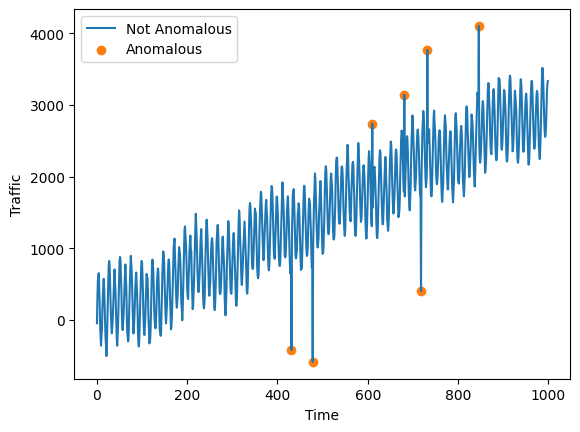

In [5]:
fig, ax = plt.subplots()
ax.plot(df["data"], label="Not Anomalous")

mask = df["label"] == 1.0
ax.scatter(df.loc[mask].index, df.loc[mask, "data"], label="Anomalous", color="tab:orange")

ax.legend()
ax.set_ylabel("Traffic")
ax.set_xlabel("Time")

Sktime provides several agorithms anomaly detection. STRAY is one such algorithm.

In [6]:
from sktime.annotation.stray import STRAY

model = STRAY()
model.fit(df["data"])
y_hat = model.transform(df["data"])  # True if anomalous, false otherwise
y_hat

0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997    False
998    False
999    False
Name: data, Length: 1000, dtype: bool

Use `sum` to find the number of anomalies that have been detected.

In [7]:
y_hat.sum()

3

Plot the predicted anomalies.

Text(0.5, 1.0, 'Predicted Anomalies')

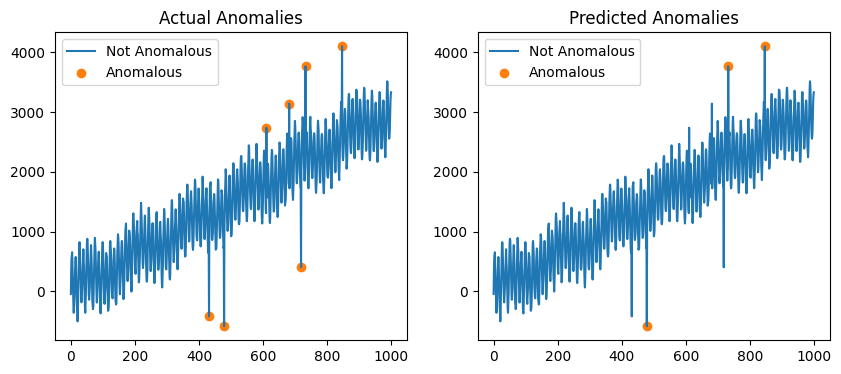

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plot the actual anomalies in the first figure
mask = df["label"] == 1.0
ax[0].plot(df["data"], label="Not Anomalous")
ax[0].scatter(df.loc[mask].index, df.loc[mask, "data"], color="tab:orange", label="Anomalous")
ax[0].legend()
ax[0].set_title("Actual Anomalies")

# Plot the predicted anomalies in the second figure
ax[1].plot(df["data"], label="Not Anomalous")
ax[1].scatter(df.loc[y_hat].index, df.loc[y_hat, "data"], color="tab:orange", label="Anomalous" )
ax[1].legend()
ax[1].set_title("Predicted Anomalies")

STRAY is a modified version of the KNN algorithm. It cannot handle the ordered trend in our data so the maximum and minimum values are the anomalies.

Sktime provides methods for removing trend.

Text(0.5, 1.0, 'Predicted Anomalies')

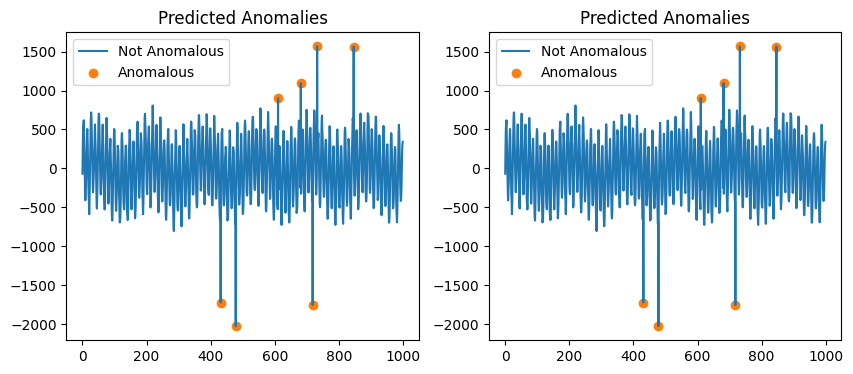

In [9]:
from sktime.transformations.series.detrend import Detrender

X_detrended = Detrender().fit_transform(df["data"])

model = STRAY()
model.fit(X_detrended)
y_hat = model.transform(X_detrended)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[1].plot(X_detrended, label="Not Anomalous")
ax[1].scatter(X_detrended.loc[y_hat].index, X_detrended.loc[y_hat], color="tab:orange", label="Anomalous")
ax[1].legend()
ax[1].set_title("Predicted Anomalies")

ax[0].plot(X_detrended, label="Not Anomalous")
ax[0].scatter(X_detrended.loc[df["label"] == 1.0].index, X_detrended.loc[df["label"] == 1.0], color="tab:orange", label="Anomalous")
ax[0].legend()
ax[0].set_title("Predicted Anomalies")

## Detecting Subsequence Outliers

Subsequence outliers are groups of consecutive points whose behaviour is unusual.

In [20]:
path = pathlib.Path(data_root / "mitdb.csv")
df = pd.read_csv(path)
df.head()

,data,label
0,-0.195,0
1,-0.210,0
2,-0.210,0
3,-0.225,0
4,-0.220,0


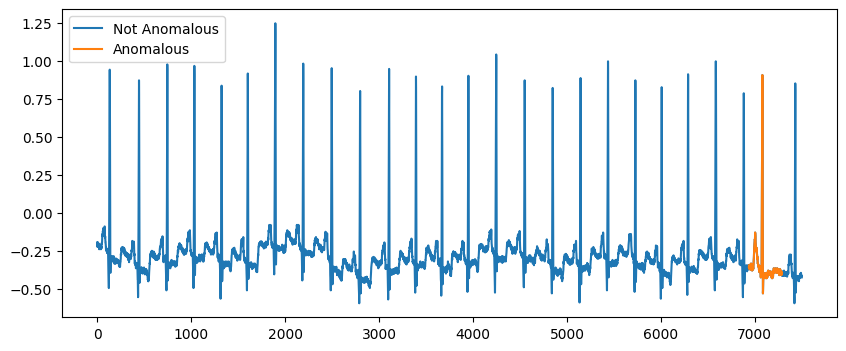

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(df["data"], label="Not Anomalous")
ax.plot(df.loc[df["label"] == 1.0, "data"], label="Anomalous")
ax.legend()

Use Capa to predict anomalous subsequence.

In [24]:
from skchange.anomaly_detectors.capa import Capa

model = Capa(max_segment_length=350)
model.fit(df["data"])
anomaly_intervals = model.predict(df["data"])
anomaly_intervals

0    [7084, 7425]
Name: anomaly_interval, dtype: interval

In [28]:
print("left: ", anomaly_intervals.iat[0].left)
print("right: ", anomaly_intervals.iat[0].right)

left:  7084
right:  7425


Capa returns a series of intervals which are the anomalous subsequences.

Plot the anomalous subsequence.

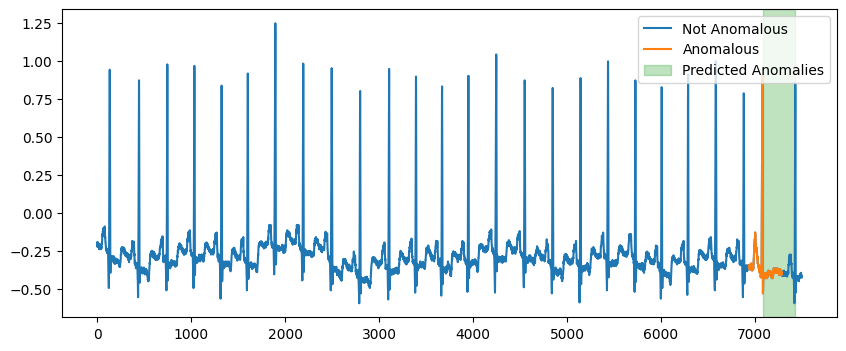

In [13]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df["data"], label="Not Anomalous")
ax.plot(df.loc[df["label"] == 1.0, "data"], label="Anomalous")

for interval in anomaly_intervals:
    left = interval.left
    right = interval.right
    ax.axvspan(left, right, color="tab:green", alpha=0.3, label="Predicted Anomalies")

ax.legend()

## Change Point Detection

Change points detection is the process of findings points in a timeseries where the underlying mechanism generating your data changes.

For this we explore the *seatbelt* dataset.

In [56]:
df = pd.read_csv(data_root / "seatbelts.csv", index_col=0)
df.index = pd.to_datetime(df.index)
df.head()

,KSI,label
1969-01-01,1687,0
1969-02-01,1508,0
1969-03-01,1507,0
1969-04-01,1385,0
1969-05-01,1632,0


Plot the seatbelt dataset.

Text(0, 0.5, 'KSI')

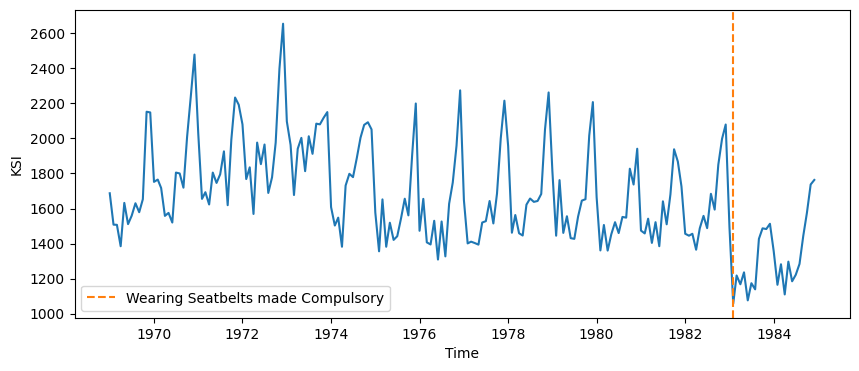

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(df["KSI"])

actual_cp = datetime.datetime(1983, 2, 1)
ax.axvline(actual_cp, color="tab:orange", linestyle="--", label="Wearing Seatbelts made Compulsory")
ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel("KSI")

It was made compulsory to wear a seatbelt in the UK on January 31st 1983. It was made mandatory to install seatbelts in new cars in 1968.

Find the change points using binary segmentation.

In [58]:
from sktime.annotation.bs import BinarySegmentation

model = BinarySegmentation(threshold=1000)
predicted_change_points = model.fit_predict(df)
print(predicted_change_points)

0   1974-12-01
1   1983-01-01
dtype: datetime64[ns]


For change point detectors, `predict` returns a series of the indexes of the change points.

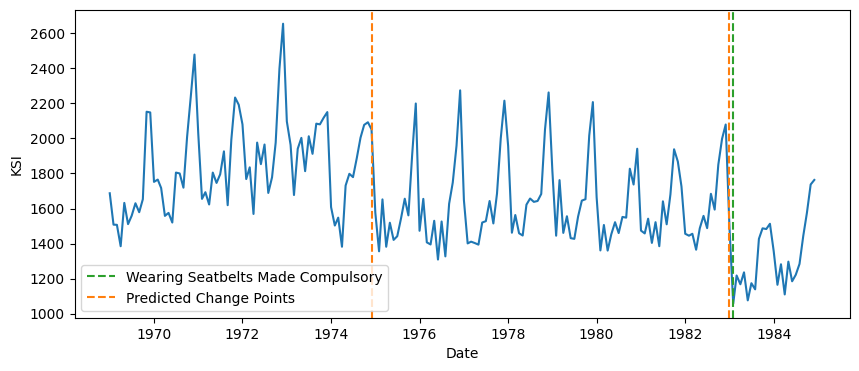

In [59]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df["KSI"])
ax.axvline(actual_cp, label="Wearing Seatbelts Made Compulsory", color="tab:green", linestyle="--")

for i, cp in enumerate(predicted_change_points):
    label = "Predicted Change Points" if i == 0 else None
    ax.axvline(cp, color="tab:orange", linestyle="--", label=label)

ax.set_ylabel("KSI")
ax.set_xlabel("Date")
ax.legend()

The nearly predicted the change point exactly.

## Change Point Scoring Metrics

* Change detection can be evaluated like a classification problem i.e. how often does the the model correctly identify change points and not change points.
* Usually change points of very rare meaning your accuracy is going to biased. Most data points should be predicted not anomalous.
* We could use F1 score instead which does not use true negatives.

Calculate the F1 score of our model using scikit-learn. First we use `sparse_to_dense` to get the predictions in a scikit-learn compatable form.

In [60]:
y_hat = model.predict(df["KSI"])
y_hat

0   1974-12-01
1   1983-01-01
dtype: datetime64[ns]

In [61]:
y_hat_dense = model.sparse_to_dense(y_hat, df.index)
y_hat_dense

1969-01-01    0
1969-02-01    0
1969-03-01    0
1969-04-01    0
1969-05-01    0
             ..
1984-08-01    0
1984-09-01    0
1984-10-01    0
1984-11-01    0
1984-12-01    0
Length: 192, dtype: int64

Calculate F1 score.

In [62]:
from sklearn.metrics import f1_score

f1_score = f1_score(df["label"], y_hat_dense)
print(f1_score)

0.0


The F1 score is zero even though our model got quite close the change point. What we need is a metric that is more foregiving if the predicted change point is close enough.

Sktime provides a metric called `padded_f1_score` which pads the true change points so that if the predicted change point is in the correct range, the prediction is deemed correct.

In [63]:
def padded_f1(true_change_points, pred_change_points, pad):
    """Calculate padded F1 score for change point detection.

    Parameters
    ----------
    true_change_points: pd.Series
        True change point positions. Can be integers, floats or datetimes.
    precicted_change_points: pd.Series
        Precicted change point positions. Can be integers, floats or datetimes.
    pad: int, float, timdelta
        Used to pad the true change points. If a predicted change point falls within
        the range of the padded change then then change point has been correctly
        identified.

    Returns
    -------
    float
        Padded f1 score

    References
    ----------
    .. [1] Gerrit J. J. van den Burg and Christopher K. I. Williams, An Evaluation of
           Change Point Detection Algorithms, 2022, https://arxiv.org/abs/2003.06222
    """
    true_change_points = pd.Series(true_change_points)
    pred_change_points = pd.Series(pred_change_points)

    boundary_left = true_change_points - pad
    boundary_right = true_change_points + pad
    true_cp_intervals = pd.IntervalIndex.from_arrays(boundary_left, boundary_right)

    false_positives = 0
    tp_and_fn = pd.Series(False, index=true_cp_intervals)

    for cp in pred_change_points:
        boolean_mask = tp_and_fn.index.contains(cp)
        if not boolean_mask.any():
            false_positives += 1
        else:
            tp_and_fn = tp_and_fn | boolean_mask

    true_positives = tp_and_fn.sum()
    false_negatives = (~tp_and_fn).sum()

    # Avoid division by zero to mimic sklearn behaviour
    denom = 2 * true_positives + false_positives + false_negatives
    if denom == 0:
        return 0.0

    padded_f1 = 2 * true_positives / denom
    return padded_f1

In [64]:
pad = pd.DateOffset(months=2)
score = padded_f1([actual_cp], model.predict(df["KSI"]), pad=pad)
print(score)

0.6666666666666666


Altering the model to predict more change points will decrease the padded F1 score.

In [65]:
model = BinarySegmentation(threshold=450)
model.fit(df["KSI"])
predicted_change_points = model.predict(df["KSI"])
predicted_change_points

0   1969-10-01
1   1974-12-01
2   1982-09-01
3   1983-01-01
4   1984-09-01
dtype: datetime64[ns]

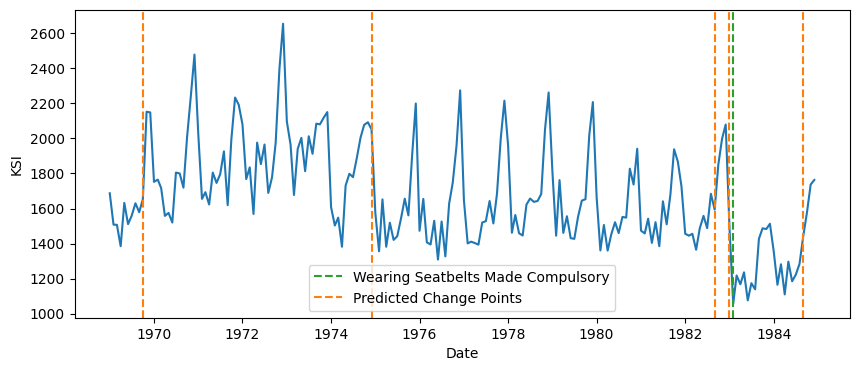

In [66]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df["KSI"])
ax.axvline(actual_cp, label="Wearing Seatbelts Made Compulsory", color="tab:green", linestyle="--")

for i, cp in enumerate(predicted_change_points):
    label = "Predicted Change Points" if i == 0 else None
    ax.axvline(cp, color="tab:orange", linestyle="--", label=label)

ax.set_ylabel("KSI")
ax.set_xlabel("Date")
ax.legend()

Find the padded F1 score.

In [67]:
pad = pd.DateOffset(months=2)
score = padded_f1([actual_cp], model.predict(df["KSI"]), pad=pad)
print(score)

0.3333333333333333


## Further Reading

* A Review on Outlier/Anomaly Detection in Time Series Data https://arxiv.org/pdf/2002.04236

## Data Sources

* https://github.com/TheDatumOrg/TSB-UAD